# SCORE Introduction

This tutorial outlines the basic functionality of the `SCORE` package. We start from the raw binned interaction files included in the `examples/data` directory of the repository and walk through the full analysis pipeline using `SCORE`.

## Creating a .scool file (`score cooler`)

`SCORE` works best when the input data is in [.scool](https://academic.oup.com/bioinformatics/article/37/14/2053/5948994) format. You can use the `score cooler` command to create a .scool file given the following inputs:

#### 1. Cell reference file

This is a tab-delimited file which must at least contain a `cell` column with the cell name/IDs. All other columns are optional and used for filtering, plotting, etc.

In [1]:
! head data/oocyte_zygote_ref

cell	depth	batch	cluster
anchor_loop.55_oocyte_NSN	130771	1	oocyte
anchor_loop.65_pronucleus-w-o_nucl_extr-female	155306	1	ZygM
anchor_loop.71_pronucleus-w-o_nucl_extr-female	134485	1	ZygM
anchor_loop.230_pronucleus-male	151376	1	ZygP
anchor_loop.58_pronucleus-female	169110	1	ZygM
anchor_loop.168_pronucleus-w-o-inh-male	3647	1	ZygP
anchor_loop.93_pronucleus-male	72157	1	ZygP
anchor_loop.34_oocyte_SN	233878	1	oocyte
anchor_loop.118_oocyte_SN	35386	1	oocyte


#### 2. Cell interaction files

These are tab-delimited files containing rows of `bin1`, `bin2`, `count` values indicating interactions in each cell.

In [2]:
! head data/oocyte_zygote_mm10/1M/anchor_loop.55_oocyte_NSN.1M

3	5	3
3	90	2
3	4	7
3	6	1
3	3	44
4	5	10
4	90	2
4	4	28
4	6	1
5	5	28


#### 3 Bin/Anchor reference file

This is a tab-delimited file containing the indices and sizes of the bins/anchors participating in each interaction. It should have columns `chrom`, `start`, `end`, `ID`.

In [3]:
! head data//mm10.genome_split_1M

chr1	1	1000001	0
chr1	1000001	2000001	1
chr1	2000001	3000001	2
chr1	3000001	4000001	3
chr1	4000001	5000001	4
chr1	5000001	6000001	5
chr1	6000001	7000001	6
chr1	7000001	8000001	7
chr1	8000001	9000001	8
chr1	9000001	10000001	9


Using these files as input to the `score cooler` command will produce a more efficient compressed representation of the dataset. By default the file will be saved at `data/scools/<dataset_name>_<resolution>.scool` but you can also provide the `--out` argument to save it somewhere else.

In [4]:
! score cooler --dset oocyte_zygote \
               --data_dir data/oocyte_zygote_mm10/1M \
               --anchor_file data/mm10.genome_split_1M \
               --reference data/oocyte_zygote_ref \
               --resolution 1M \
               --out oocyte_zygote_1M.scool

Dataset: oocyte_zygote
Total Cells: 169
ZygP: 35
oocyte: 98
ZygM: 36
100%|█████████████████████████████████████████| 169/169 [01:05<00:00,  2.56it/s]
0


## Embedding the data

Now you can use the `--scool` argument to provide the dataset to the `score embed` command. Note that you can run most (not all) embedding functionality using the `--data_dir` and `--anchor_file` arguments with raw data but it will not be as efficient in loading each cell.

In [23]:
! score embed --dset oocyte_zygote \
              --scool oocyte_zygote_1M.scool \
              --reference data/oocyte_zygote_ref \
              --embedding_algs scHiCluster InnerProduct cisTopic

Dataset: oocyte_zygote
Resolution not provided, inferring from bins, make sure this is right...
Inferred 1M resolution...
Total Cells: 169
Cells before filtering: 169
Cells before filtering by chr: 152
not filtered : 150
reference depth < min_depth : 17
chr_reads < chr_length : 2
Reference file with filtering criteria saved to data/oocyte_zygote_filtered_ref
ZygP: 28
oocyte: 95
ZygM: 27
Embedding data using:
['scHiCluster', 'InnerProduct', 'cisTopic']

oocyte_zygote - schicluster:vc_sqrt_norm,convolution,random_walk
Preprocessing cells... ['vc_sqrt_norm', 'convolution', 'random_walk']
 76%|████████████████████████████████▊          | 16/21 [00:24<00:07,  1.54s/it]/mnt/rds/genetics01/JinLab/dmp131/.conda/envs/hiscore/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:685: RuntimeWarning: invalid value encountered in divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var
100%|███████████████████████████████████████████| 21/21 [00:32<00:00,  1.54s/it]
Runnin

The results will by default be stored in a `results/<dataset_name>/<resolution>` directory which can be changed by specifying the `--out` argument. Of main interest is the visualization of the embeddings using PCA, t-SNE, and UMAP which is stored as `embedding.png/pdf`

In [6]:
from IPython.display import Image

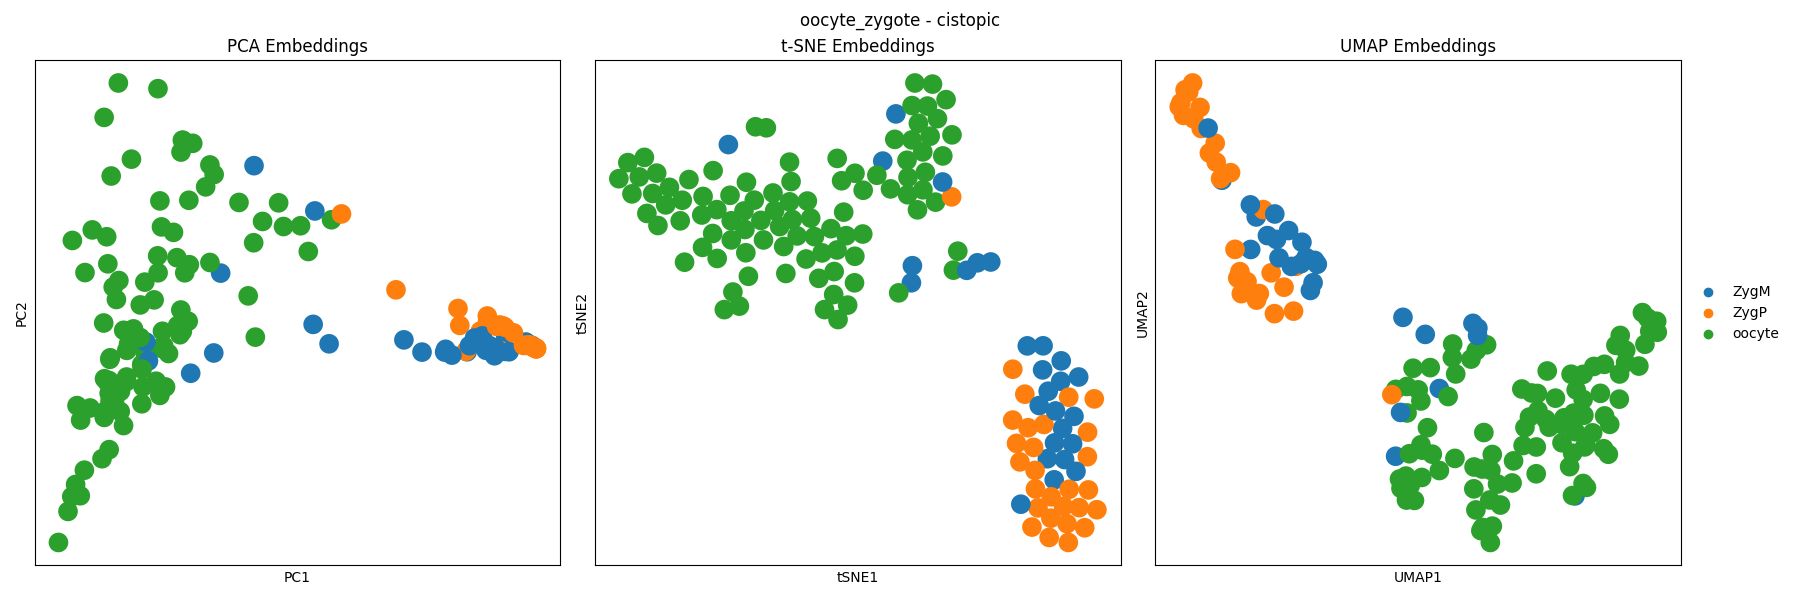

In [7]:
Image(filename='results/oocyte_zygote/1M/cistopic/celltype_plots/embedding.png') 

Any columns in the reference file that are categorical or numerical metadata such as read depth or batch will be visualized in the `other_feats` directory:

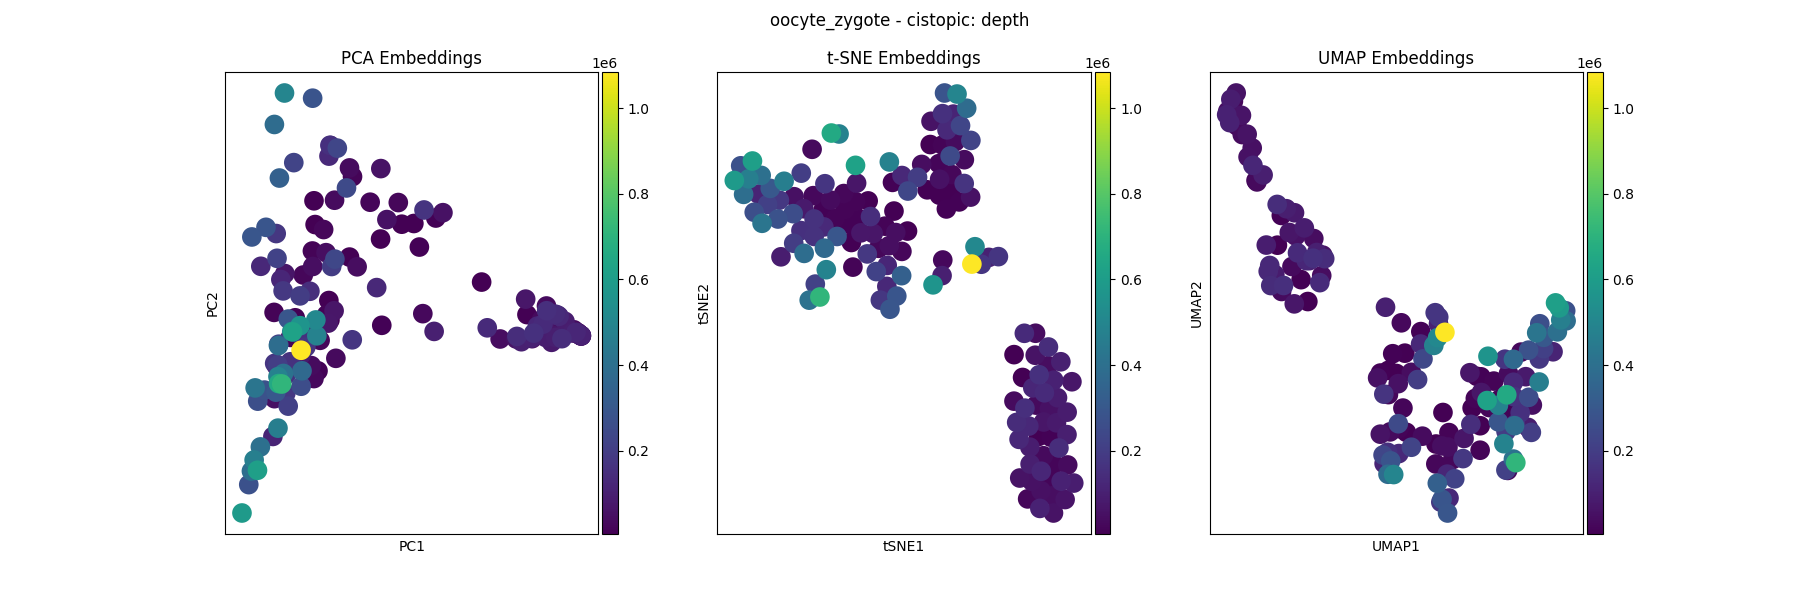

In [24]:
Image(filename='results/oocyte_zygote/1M/cistopic/other_feats/embedding_depth.png') 

You can also load the saved `AnnData` object using `scanpy` to run your own embedding visualization and analysis.

In [18]:
import scanpy as sc

adata = sc.read('results/oocyte_zygote/1M/cistopic/anndata_obj.h5ad')
adata

AnnData object with n_obs × n_vars = 150 × 10
    obs: 'cell', 'celltype', 'cluster', 'batch', 'depth', 'k-means', 'agglomerative', 'gmm', 'louvain', 'leiden'
    uns: 'leiden', 'louvain', 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

/mnt/rds/genetics01/JinLab/dmp131/.conda/envs/hiscore/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


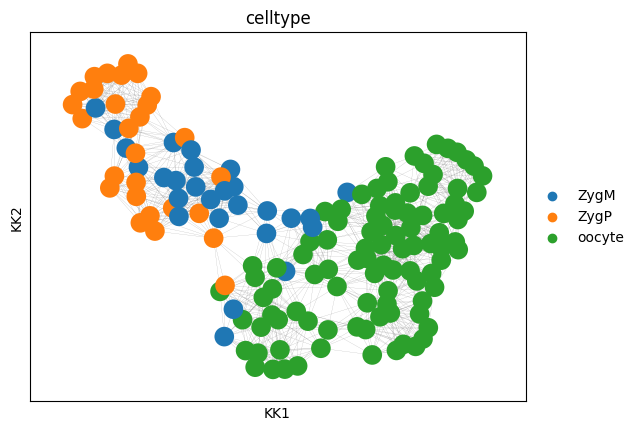

In [22]:
sc.tl.draw_graph(adata, layout='kk')
sc.pl.draw_graph(adata, color=['celltype'], edges=True)

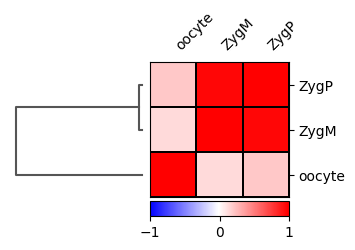

In [20]:
sc.pl.correlation_matrix(adata, groupby='celltype')